In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append('/home/xilinx/jupyter_notebooks/qickdawg/src/')

import qickdawg as qd
from copy import copy
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks

In [2]:
qd.start_client(bitfile="/home/xilinx/jupyter_notebooks/qickdawg/firmware/photon_counting/qick_4x2.bit")

In [3]:
min_step_us = qd.soccfg.cycles2us(1) # this is the minimum step size in us, which is the time for one clock cycle
min_step_ns = min_step_us*1e3
max_int_time_us = min_step_us * (2**16 - 1)
max_int_time_ns = min_step_ns * (2**16 - 1)

In [46]:
default_config = qd.NVConfiguration()

default_config.test = True
default_config.mw_readout_channel = 1
default_config.ddr4 = True
default_config.ddr4_channel = 0
default_config.n_ddr4_chunks = 20000

default_config.adc_channel = 0 

default_config.mw_channel = 1
default_config.mw_nqz = 1
default_config.mw_gain = 5000

default_config.laser_gate_pmod = 0

default_config.relax_delay_treg = 100 # between each rep, wait for everything to catch up, mostly aom


In [47]:
config = copy(default_config)

config.soft_avgs = 1
config.readout_integration_treg = 1020
prog = qd.LaserOn(config)
_ = prog.acquire_decimated(progress=False)
data = prog.acquire_decimated(progress=False)
on_value  = np.mean(data)
print('Approximate on intensity {} ADC units'.format(on_value))

prog = qd.LaserOff(config)
_ = prog.acquire_decimated(progress=False)
data = prog.acquire_decimated(progress=False)
off_value  = np.mean(data)
print('Approximate off intensity {} ADC units'.format(off_value))


Approximate on intensity 1709.9343137254903 ADC units
Approximate off intensity 1.2549019607843137 ADC units


In [60]:
for i in range(2):
    
    qd.soc.clear_ddr4()

    config = copy(default_config)
    
    config.mw_gain = 30000
    config.mw_fMHz = 2870
    config.mw_pi2_treg = 100
    
    config.pre_init = False

    config.relax_delay_treg = 100

    config.laser_on_treg = 5000 # in us
    config.readout_integration_treg = 700  # us
    config.readout_reference_start_treg = 3500 # us

    config.laser_readout_offset_treg = 0 #
    config.mw_readout_delay_treg = 100

    config.add_exponential_sweep('delay', 'tus', start=0.05, stop=10000, scaling_factor='3/2')

    config.reps = 1

    config.ddr4_channel = i

    prog = qd.T1DelaySweep(config)
    d = prog.acquire(progress=True)

    if i == 0:
        laser_ddr4 = qd.soc.get_ddr4(config.n_ddr4_chunks)[:, 0]
    elif i == 1:
        mw_ddr4 = qd.soc.get_ddr4(config.n_ddr4_chunks)
        mw_real = mw_ddr4[:, 0]
        mw_imag = mw_ddr4[:, 1]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

In [61]:
phase = 0.21
phase = np.arctan(np.mean(mw_real[300:800]) / np.mean(mw_imag[300:800]))
phase -= np.pi/2

x = mw_real * np.cos(phase) - mw_imag * np.sin(phase)
y = mw_real * np.sin(phase) + mw_imag * np.cos(phase)

# plt.plot(laser_ddr4, label='Laser')
# plt.plot(x, label='Microwave I')
# plt.plot(y, label='Microwave Q')
# # plt.xlim(0, 1200)
# plt.legend()

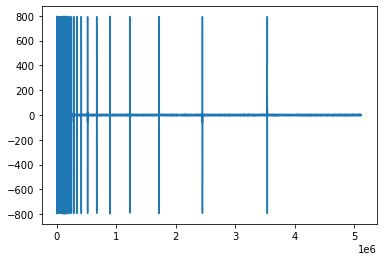

In [62]:
plt.plot(np.gradient(x))

In [63]:
laser_start_treg = find_peaks(np.gradient(laser_ddr4), height=200)[0]
laser_end_treg = find_peaks(np.gradient(-laser_ddr4), height=200)[0]
mw_start_treg = find_peaks(np.gradient(np.abs(x)), height=150)[0]
mw_end_treg = find_peaks(np.gradient(-np.abs(x)), height=150)[0]

laser_norm = laser_ddr4 /np.max(laser_ddr4)
x_norm = x /np.max(x)

In [74]:
plt.plot(laser_ddr4/np.max(laser_ddr4) + 1.5, label='Laser')
plt.plot(x/np.max(x), label='Microwave I')
# plt.plot(y, label='Microwave Q')
plt.legend()
plt.show()

for i in range(len(mw_start_treg) - 5):
    plt.plot(x_norm[mw_start_treg[i]: laser_end_treg[2 * i]] + i * 1.5)
    plt.plot(laser_norm[mw_start_treg[i]: laser_end_treg[2 * i]] +  i * 1.5)

# plt.plot(x_norm[mw_start_treg[1]: laser_end_treg[3]])


KeyboardInterrupt: 

In [75]:
# should be equal to the mw pulse time in treg for 2 * pi/2

mw_end_treg - mw_start_treg

array([200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200,
       200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200,
       200, 200])

In [76]:
# should be equal to the readout window time in treg

laser_end_treg - laser_start_treg

array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000,
       5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000,
       5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000,
       5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000,
       5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000])

In [77]:
# Should be 4 * mw_pi2_treg + 2 * delay_treg + laser_on_treg + mw_readout_delay_treg + laser_readout_offset_treg - adc_trigger_offset_treg
# this should only change by delay * 2 time

sequence_time = []

for i in range(len(mw_start_treg)):
    sequence_time.append(laser_end_treg[2 * i] - mw_start_treg[i])

print([sequence_time[i] - sequence_time[0] for i in range(len(sequence_time))])

[0, 7, 18, 34, 58, 94, 148, 229, 351, 534, 808, 1219, 1836, 2761, 4149, 6231, 9354, 14038, 21064, 31603, 47412, 71125, 106695, 160050, 240082, 360130, 540202, 810310]


In [78]:
print(prog.asm())


// Program

            regwi 1, $22, 626961066;            //freq = 2507844267
            bitwi 1, $22, $22 << 2;
            mathi 1, $22, $22 + 3;
            regwi 1, $25, 30000;                //gain = 30000
            regwi 1, $23, 0;                    //phase = 0
            regwi 1, $26, 589924;               //phrst| stdysel | mode | | outsel = 0b01001 | length = 100 
            regwi 1, $1, 15;                    //'delay' <= 15 
            synci 100;
            regwi 0, $16, 8192;                 //out = 0b0010000000000000
            seti 7, 0, $16, 0;                  //ch =0 out = $16 @t = 0
            seti 7, 0, $0, 10;                  //ch =0 out = 0 @t = 0
            synci 100;
            regwi 0, $13, 0;
            regwi 0, $14, 0;
LOOP_rep:   regwi 1, $1, 15;                    //'delay' <= 15 
            regwi 0, $17, 31;
LOOP_delay: regwi 1, $27, 0;                    //t = 0
            set 1, 1, $22, $23, $0, $25, $26, $27;//ch = 1, pulse @t = $27
  

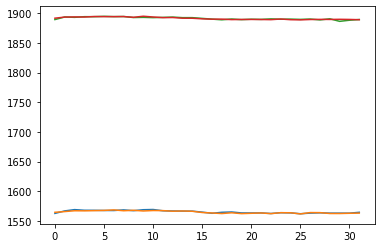

In [73]:
plt.plot(d.signal1/prog.cfg.readout_integration_treg)
plt.plot(d.signal2/prog.cfg.readout_integration_treg)
plt.plot(d.reference1/prog.cfg.readout_integration_treg)
plt.plot(d.reference2/prog.cfg.readout_integration_treg)